In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline   
import warnings
warnings.filterwarnings("ignore")

# Printing config:
pd.options.display.float_format = '{:,.4f}'.format
#np.random.seed(42)


# # # # Main Parameters # # # #
dataFilePath = "./usage_records.csv"
#actPlotsFlag = True


# Load the data
data_df = pd.read_csv(dataFilePath)

# Convert relevant columns to datetime type:
date_cols = ['subscription_date', 'redshifted_at']
for col in date_cols:
    data_df.loc[:, col] = pd.to_datetime(data_df.loc[:, col])

In [166]:
# # # # DADA ANALYSIS # # # #

print("\nData head:\n" + str(data_df.head()))
print("\nData shape: " + str(data_df.shape))  

# Checking cols data type and existence of missing values 
print(("\nData info: \n%s") % data_df.info())  
print(("\nMissing values: \n%s") % data_df.isnull().sum( ))  # no missing values

# Check data validity:
groupby_cols = ['id','renewed']
print("\nValidatiov: each 'id' has only one label - %s" % 
      (len(data_df.groupby(groupby_cols).size()) == len(data_df.id.unique())))
groupby_cols = ['id','subscription_date']
print("Validatiov: each 'id' has only one subscription_date - %s" % 
      (len(data_df.groupby(groupby_cols).size()) == len(data_df.id.unique())))
print("Validatiov: all 'redshifted_at' values are later (or equal to) 'subscription_date' - %s" % 
      (sum(data_df.subscription_date <= data_df.redshifted_at) == data_df.shape[0]))
      
# Basic statistics:
num_of_users = len(data_df.id.unique())
num_of_churned_users = len(data_df[data_df['renewed'] == False].id.unique())
print(("\nThere are %d churned users out of %d users (%.4f percent)") % 
      (num_of_churned_users,
       num_of_users,
       100 * num_of_churned_users / num_of_users))
print(("\nPopular features normalized frequency: \n%s") % 
      data_df.feature_name.value_counts(normalize=True).head())

# Analysis per label:
# Number of actions:
groupby_cols = ['renewed', 'id']
label_id_counts_df = data_df.groupby(groupby_cols).size().reset_index(name='counts')
print("\n\nActivity stats of churned users: \n%s" % 
label_id_counts_df[label_id_counts_df['renewed'] == False].counts.describe())
print("\nActivity stats of renewed users: \n%s" % 
label_id_counts_df[label_id_counts_df['renewed'] == True].counts.describe())
# Number of features being used:
unique_fe_by_label_id_df = data_df.groupby(groupby_cols).agg({"feature_name": lambda x: x.nunique()})
unique_fe_by_label_id_df.reset_index(inplace=True)
print("\n\nAmount of used features stats of churned users: \n%s" % 
      unique_fe_by_label_id_df[unique_fe_by_label_id_df['renewed'] == False].feature_name.describe())
print("\nAmount of used features stats of renewed users: \n%s" % 
      unique_fe_by_label_id_df[unique_fe_by_label_id_df['renewed'] == True].feature_name.describe())
# Min / Max 'subscription_date':
print("\n\nChurned users subscription_date: min - %s, max - %s" % 
      (data_df[data_df['renewed'] == False].subscription_date.min(),
       data_df[data_df['renewed'] == False].subscription_date.max()))
print("Renewed users subscription_date: min - %s, max - %s" % 
      (data_df[data_df['renewed'] == True].subscription_date.min(),
       data_df[data_df['renewed'] == True].subscription_date.max()))
# Min / Max 'redshifted_at':
print("\nChurned users redshifted_at: min - %s, max - %s" % 
      (data_df[data_df['renewed'] == False].redshifted_at.min(),
       data_df[data_df['renewed'] == False].redshifted_at.max()))
print("Renewed users redshifted_at: min - %s, max - %s" % 
      (data_df[data_df['renewed'] == True].redshifted_at.min(),
       data_df[data_df['renewed'] == True].redshifted_at.max()))



Data head:
     id  renewed   subscription_date  feature_name       redshifted_at  \
0  5147    False 2017-10-13 17:12:41            20 2017-10-21 13:05:45   
1  7423    False 2017-10-08 19:18:56            25 2017-10-08 19:52:00   
2  3491     True 2017-10-10 15:08:54            18 2017-10-11 16:47:53   
3  9891     True 2017-10-15 01:12:10             3 2017-10-15 01:22:11   
4  6378     True 2017-10-23 00:31:45            35 2017-10-28 16:57:53   

   churned  days_since_sub  weeks_since_sub  sub_week  
0     True               8                2        41  
1     True               1                1        40  
2    False               2                1        41  
3    False               1                1        41  
4    False               6                1        43  

Data shape: (1162830, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1162830 entries, 0 to 1162829
Data columns (total 9 columns):
id                   1162830 non-null int64
renewed              1162

In [8]:
# TODO: REMOVE this cel!!!
# Load the data
data_df = pd.read_csv(dataFilePath)

# Convert relevant columns to datetime type:
date_cols = ['subscription_date', 'redshifted_at']
for col in date_cols:
    data_df.loc[:, col] = pd.to_datetime(data_df.loc[:, col])

# Label extraction - 'churned' (!renewed):
label = 'churned'
data_df[label] = (data_df['renewed'] == False)

# FEATURE EXTRACTION
# Compute days since subsrciption (redshifted_at - subscription_date):
data_df['days_since_sub'] = (data_df['redshifted_at'] - data_df['subscription_date']).dt.ceil("D").dt.days
# Compute weeks since subscription (w1:0-7, w2:8-14, w3:15-21, w4:22-28)
data_df['weeks_since_sub'] = pd.to_numeric(np.ceil(data_df['days_since_sub'] / 7), downcast='signed')
data_df.loc[data_df.loc[:, 'weeks_since_sub'] == 0, 'weeks_since_sub'] = 1

# Compute subscription week number:
data_df['sub_week'] = data_df['subscription_date'].apply(lambda x: x.isocalendar()[1])
data_df.head()

,id,renewed,subscription_date,feature_name,redshifted_at,churned,days_since_sub,weeks_since_sub,sub_week
0,5147,False,2017-10-13 17:12:41,20,2017-10-21 13:05:45,True,8,2,41
1,7423,False,2017-10-08 19:18:56,25,2017-10-08 19:52:00,True,1,1,40
2,3491,True,2017-10-10 15:08:54,18,2017-10-11 16:47:53,False,2,1,41
3,9891,True,2017-10-15 01:12:10,3,2017-10-15 01:22:11,False,1,1,41
4,6378,True,2017-10-23 00:31:45,35,2017-10-28 16:57:53,False,6,1,43


In [ ]:
# Analysis:
groupby_cols = ['id', label, 'weeks_since_sub']
data_df[groupby_cols].groupby(groupby_cols, as_index=False).size().groupby([label, 'weeks_since_sub']).mean()

In [60]:
# Generate subscription week number features:
user_sub_week_df = data_df.loc[:, ['id', 'sub_week']].drop_duplicates()
user_sub_week_df.set_index('id', inplace=True)
user_sub_week_df.sub_week = user_sub_week_df.sub_week.apply(str)
sub_week_dummies_df = pd.get_dummies(user_sub_week_df)#data_df.loc[:, ['id', 'sub_week']].drop_duplicates(), 
sub_week_dummies_df.head()

,sub_week_39,sub_week_40,sub_week_41,sub_week_42,sub_week_43,sub_week_44
id,,,,,,
5147,0,0,1,0,0,0
7423,0,1,0,0,0,0
3491,0,0,1,0,0,0
9891,0,0,1,0,0,0
6378,0,0,0,0,1,0


In [9]:
# Generate features - combinations of feature_name & weeks from subscription 
# (e.g. w2_f1 represents the usage of feature_name 1 during week 2)
groupby_cols = ['id', 'feature_name', 'weeks_since_sub'] 
user_fe_act_per_week_df = data_df.groupby(groupby_cols).size().unstack(['weeks_since_sub', 'feature_name'])
new_col_names = ['w' + str(a) + '_f' + str(b)  for a,b in user_fe_act_per_week_df.columns.get_values()] 
user_fe_act_per_week_df.columns = new_col_names
cols = user_fe_act_per_week_df.columns
for i in range(1,5):
    w_fe_list = cols[np.where([x.startswith('w'+str(i)) for x in cols])[0]] # finds the features of the relevant week
    #DEBUG: print(w_fe_list); print(user_fe_act_per_week_df[w_fe_list].sum(axis=1).head())
    user_fe_act_per_week_df['sum_w'+str(i)] = user_fe_act_per_week_df[w_fe_list].sum(axis=1)
    #user_fe_act_per_week_df[w_fe_list] = user_fe_act_per_week_df[w_fe_list].div(user_fe_act_per_week_df['sum_w'+str(i)], axis=0)
    
    w_fe_len = len(w_fe_list)
    user_fe_act_per_week_df['uniq_fe_w'+str(i)] = w_fe_len - user_fe_act_per_week_df[w_fe_list].isnull().sum(axis=1)
cols = user_fe_act_per_week_df.columns
drop_cols = cols[np.where([x.startswith('sum_w') for x in cols])[0]]
user_fe_act_per_week_df.drop(columns=drop_cols, inplace=True)


user_fe_act_per_week_df.head()

,w1_f3,w1_f15,w1_f16,w1_f31,w2_f31,w1_f32,w2_f32,w1_f6,w1_f7,w2_f14,...,w4_f40,w4_f56,w3_f65,w4_f65,w3_f59,w2_f22,uniq_fe_w1,uniq_fe_w2,uniq_fe_w3,uniq_fe_w4
id,,,,,,,,,,,,,,,,,,,,,
1,1.0000,3.0000,1.0000,1.0000,1.0000,5.0000,5.0000,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,5,2,0,0
2,2.0000,nan,nan,6.0000,nan,4.0000,nan,3.0000,5.0000,1.0000,...,nan,nan,nan,nan,nan,nan,11,4,0,0
3,1.0000,4.0000,1.0000,2.0000,nan,5.0000,nan,1.0000,2.0000,nan,...,nan,nan,nan,nan,nan,nan,20,0,0,0
4,nan,nan,20.0000,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,12,4,1,1
5,4.0000,2.0000,1.0000,5.0000,nan,2.0000,nan,5.0000,5.0000,nan,...,nan,nan,nan,nan,nan,nan,29,0,8,0


In [62]:
# Generate 'feature_name' usage features:
groupby_cols = ['id', label, 'feature_name', 'days_since_sub'] 
user_fe_act_per_dss_df = data_df.groupby(groupby_cols).size().reset_index().rename(columns={0: 'count'})
max_days_since_sub = user_fe_act_per_dss_df['days_since_sub'].max()
user_fe_act_per_dss_df['weight'] = user_fe_act_per_dss_df['days_since_sub'] / max_days_since_sub
user_fe_act_per_dss_df['w_count'] = user_fe_act_per_dss_df['weight'] * user_fe_act_per_dss_df['count']
# DEBUG: print(user_fe_act_per_dss_df[user_fe_act_per_dss_df['id'] == 1])
groupby_cols.remove('days_since_sub')
user_fe_act_df = user_fe_act_per_dss_df.groupby(groupby_cols).sum()
pp_data_df = user_fe_act_df.w_count.unstack('feature_name').reset_index().set_index('id')
# DEBUG: print(pp_data_df.loc[:,[3,15,16,31,32,50]].head())
pp_data_df.columns = pd.Series(list(pp_data_df.columns)).apply(lambda x: 'fe_name_' + str(x))
pp_data_df.rename(columns={'fe_name_churned': label}, inplace=True)
pp_data_df.head()

,churned,fe_name_1,fe_name_2,fe_name_3,fe_name_4,fe_name_5,fe_name_6,fe_name_7,fe_name_8,fe_name_9,...,fe_name_58,fe_name_59,fe_name_60,fe_name_61,fe_name_62,fe_name_63,fe_name_64,fe_name_65,fe_name_66,fe_name_67
id,,,,,,,,,,,,,,,,,,,,,
1,False,nan,nan,0.1786,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2,False,nan,nan,0.0714,nan,nan,0.1071,0.1786,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
3,True,nan,nan,0.0357,nan,nan,0.0357,0.0714,nan,nan,...,nan,nan,nan,nan,0.1071,nan,0.1786,nan,nan,nan
4,False,nan,nan,nan,0.5357,0.1786,nan,nan,0.0357,nan,...,nan,nan,nan,nan,nan,0.0357,nan,nan,nan,nan
5,True,nan,0.4286,0.2143,0.1429,1.4286,0.4286,1.1429,0.4286,nan,...,nan,nan,nan,nan,0.4286,nan,1.1071,nan,nan,nan


In [63]:
# Join all feature groups:
pp_data_df = pp_data_df.join(sub_week_dummies_df)
pp_data_df = pp_data_df.join(user_fe_act_per_week_df)
pp_data_df.head()

,churned,fe_name_1,fe_name_2,fe_name_3,fe_name_4,fe_name_5,fe_name_6,fe_name_7,fe_name_8,fe_name_9,...,w4_f40,w4_f56,w3_f65,w4_f65,w3_f59,w2_f22,uniq_fe_w1,uniq_fe_w2,uniq_fe_w3,uniq_fe_w4
id,,,,,,,,,,,,,,,,,,,,,
1,False,nan,nan,0.1786,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,5,2,0,0
2,False,nan,nan,0.0714,nan,nan,0.1071,0.1786,nan,nan,...,nan,nan,nan,nan,nan,nan,11,4,0,0
3,True,nan,nan,0.0357,nan,nan,0.0357,0.0714,nan,nan,...,nan,nan,nan,nan,nan,nan,20,0,0,0
4,False,nan,nan,nan,0.5357,0.1786,nan,nan,0.0357,nan,...,nan,nan,nan,nan,nan,nan,12,4,1,1
5,True,nan,0.4286,0.2143,0.1429,1.4286,0.4286,1.1429,0.4286,nan,...,nan,nan,nan,nan,nan,nan,29,0,8,0


In [ ]:
# Analysis:
sub_cols = [label, 'uniq_fe_w1', 'uniq_fe_w2', 'uniq_fe_w3', 'uniq_fe_w4']
print(pp_data_df[sub_cols].groupby(label, as_index=False).mean())
print(pp_data_df.loc[pp_data_df[label] == True, sub_cols].describe())
print(pp_data_df.loc[pp_data_df[label] == False, sub_cols].describe())

In [64]:
# FEATURE REDUCTION
# Combining rare features per feature group (fe_name_other, w1_other, w2_other, ...):
fe_missing_val_sr = pp_data_df.isnull().sum( )
num_of_users = pp_data_df.shape[0]
missing_val_threshold = 0.999 # rare feature - less than 0.1% occurences 
rare_fe_list = fe_missing_val_sr[(fe_missing_val_sr / num_of_users) > missing_val_threshold].index

pp_data_df.fillna(0, inplace=True)

print("DEBUG: preprocessed data (pp_data_df) shape BEFORE: " + str(pp_data_df.shape))
fe_groups = ['fe_name_', 'w1_', 'w2_', 'w3_', 'w4_']
for fe_grp in fe_groups:
    grp_rare_fe_list = rare_fe_list[np.where([x.startswith(fe_grp) for x in rare_fe_list])[0]] # finds the rare features of the relevant week
    pp_data_df[fe_grp + 'other'] = pp_data_df[grp_rare_fe_list].sum(axis=1)
    print("Combining %d %s features into 1 new feature" % (len(grp_rare_fe_list), fe_grp))
pp_data_df.drop(columns=rare_fe_list, inplace=True)
print("DEBUG: preprocessed data (pp_data_df) shape AFTER: " + str(pp_data_df.shape))
pp_data_df.head()


DEBUG: preprocessed data (pp_data_df) shape BEFORE: (10167, 334)
Combining 4 fe_name_ features into 1 new feature
Combining 4 w1_ features into 1 new feature
Combining 8 w2_ features into 1 new feature
Combining 8 w3_ features into 1 new feature
Combining 11 w4_ features into 1 new feature
DEBUG: preprocessed data (pp_data_df) shape AFTER: (10167, 304)


,churned,fe_name_1,fe_name_2,fe_name_3,fe_name_4,fe_name_5,fe_name_6,fe_name_7,fe_name_8,fe_name_9,...,w2_f42,uniq_fe_w1,uniq_fe_w2,uniq_fe_w3,uniq_fe_w4,fe_name_other,w1_other,w2_other,w3_other,w4_other
id,,,,,,,,,,,,,,,,,,,,,
1,False,0.0000,0.0000,0.1786,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,5,2,0,0,0.0000,0.0000,0.0000,0.0000,0.0000
2,False,0.0000,0.0000,0.0714,0.0000,0.0000,0.1071,0.1786,0.0000,0.0000,...,0.0000,11,4,0,0,0.0000,0.0000,0.0000,0.0000,0.0000
3,True,0.0000,0.0000,0.0357,0.0000,0.0000,0.0357,0.0714,0.0000,0.0000,...,0.0000,20,0,0,0,0.0000,0.0000,0.0000,0.0000,0.0000
4,False,0.0000,0.0000,0.0000,0.5357,0.1786,0.0000,0.0000,0.0357,0.0000,...,0.0000,12,4,1,1,0.0000,0.0000,0.0000,0.0000,0.0000
5,True,0.0000,0.4286,0.2143,0.1429,1.4286,0.4286,1.1429,0.4286,0.0000,...,0.0000,29,0,8,0,0.0000,0.0000,0.0000,0.0000,0.0000


In [103]:
# Check if the churned & renewd data are coming from different poisson distribution - 
#       using MLE for each feature and population:
import scipy.stats as st

# From MLE, the lambda estimator of Poisson distribution is: sum(x_i)/n 
# Where the summation is for i in 1:n, n is the number of observations.
# We will generate samples from Poisson dist with the estimated lambda and 
# check the hypothesis that our data is comimg from the same distribution.
# If so, and in case there is a significant distance between the churned and renewd users population we can use it 
# for classification
groupby_cols = ['id', label, 'feature_name']
df = data_df[groupby_cols].groupby(groupby_cols).size().unstack(['feature_name']).reset_index()
# DEBUG: 
print(df.head())
churned = df[df[label] == True].drop(columns=['id', label]).fillna(0).mean(axis=0)
renewed = df[df[label] == False].drop(columns=['id', label]).fillna(0).mean(axis=0)
print(churned)
#churned = df[df[label] == True].groupby('feature_name').mean()
#renewed = df[df[label] == False].groupby('feature_name').mean()
mean_diff = churned.to_frame().join(renewed.to_frame(), lsuffix='_churned', rsuffix='_renewed')
mean_diff['diff'] = mean_diff['0_renewed'] - mean_diff['0_churned']
mean_diff[['0_churned', '0_renewed', 'diff']].sort_values(by='diff', ascending=False)

feature_name  id  churned   1      2      3      4      5      6      7  \
0              1    False nan    nan 1.0000    nan    nan    nan    nan   
1              2    False nan    nan 2.0000    nan    nan 3.0000 5.0000   
2              3     True nan    nan 1.0000    nan    nan 1.0000 2.0000   
3              4    False nan    nan    nan 2.0000 5.0000    nan    nan   
4              5     True nan 5.0000 4.0000 3.0000 4.0000 5.0000 6.0000   

feature_name      8 ...  58  59  60  61     62     63     64  65  66  67  
0               nan ... nan nan nan nan    nan    nan    nan nan nan nan  
1               nan ... nan nan nan nan    nan    nan    nan nan nan nan  
2               nan ... nan nan nan nan 3.0000    nan 5.0000 nan nan nan  
3            1.0000 ... nan nan nan nan    nan 1.0000    nan nan nan nan  
4            5.0000 ... nan nan nan nan 5.0000    nan 5.0000 nan nan nan  

[5 rows x 69 columns]
feature_name
1    1.8339
2    1.0487
3    4.7893
4    0.7299
5    2.6877
6  

,0_churned,0_renewed,diff
feature_name,,,
15,8.6951,11.1469,2.4518
31,5.5633,7.6801,2.1168
3,4.7893,6.6580,1.8687
29,7.1517,8.7736,1.6218
32,3.9805,5.4124,1.4319
20,5.0241,6.2986,1.2744
64,4.1179,5.3518,1.2340
25,3.4367,4.3598,0.9232
19,2.9517,3.8052,0.8534


In [94]:
feature_name = 15
lam_renewed = mean_diff.loc[feature_name, '0_renewed']
lam_churned = mean_diff.loc[feature_name, '0_churned']

id_label = data_df[['id', label]].drop_duplicates()
n_renewed = sum(id_label[label] == False)
n_churned = sum(id_label[label] == True)

poi_var_renewed = np.random.poisson(lam=lam_renewed, size=n_renewed)
poi_var_churned = np.random.poisson(lam=lam_churned, size=n_churned)
print(poi_var_renewed)
print(poi_var_churned)

[10 17 13 ...,  9 15 17]
[ 8 11 17 ..., 10 16  7]


In [96]:
print(n_renewed)
print(n_churned)
print(n_churned+n_renewed)

8012
2155
10167


In [149]:
feature_names = [15, 31, 3]
means = pd.DataFrame()
variances = list()
for i in range(3):
    #means.append(df[df[label] == False].sample(2000).loc[:,feature_names].fillna(0).mean(axis=0), ignore_index=True)
    #variances.append(df[df[label] == False].sample(2000).loc[:,feature_names].fillna(0).var(axis=0))
    print(df[df[label] == False].sample(2000).loc[:,feature_names].fillna(0).mean(axis=0))
    print(df[df[label] == False].sample(2000).loc[:,feature_names].fillna(0).var(axis=0))

feature_name
15   10.7950
31    7.2000
3     6.7025
dtype: float64
feature_name
15   460.6572
31   228.0670
3    150.3516
dtype: float64
feature_name
15   12.1130
31    7.8540
3     6.7050
dtype: float64
feature_name
15   460.6557
31   178.6613
3    194.0043
dtype: float64
feature_name
15   10.5370
31    7.6270
3     7.0575
dtype: float64
feature_name
15   392.6644
31   179.9662
3    192.9593
dtype: float64


In [150]:
print(df[df[label] == True].sample(2000).loc[:,feature_names].fillna(0).mean(axis=0))
print(df[df[label] == True].sample(2000).loc[:,feature_names].fillna(0).var(axis=0))
#pd.Series(means).describe()
# 15	8.6951	11.1469	2.4518


feature_name
15   8.5195
31   5.5545
3    4.7615
dtype: float64
feature_name
15   444.5632
31   114.6363
3    101.6248
dtype: float64


In [139]:
print(means[0:15])
print(variances[0:15])

[10.2195, 11.606, 11.125, 11.085, 10.136, 11.2165, 11.2165, 11.6135, 11.195, 11.8325, 11.008, 11.5895, 11.415, 11.3585, 10.8825]
[506.1338179089567, 623.8252486243078, 435.1932043521777, 502.4900360180081, 620.8179267133622, 524.2857826413189, 392.8371123061515, 623.2687281140569, 492.83329639819357, 456.0179929964926, 510.6764742371131, 404.80621910955557, 499.5445082541204, 497.83138669334915, 533.6923039019457]


In [152]:
m = 8.5195
v = 444.5632
k = ( m * m) / (v - m)
k

0.1664555186785178

In [153]:
v/m

52.18184165737426

In [157]:
data_df.head()

,id,renewed,subscription_date,feature_name,redshifted_at,churned,days_since_sub,weeks_since_sub,sub_week
0,5147,False,2017-10-13 17:12:41,20,2017-10-21 13:05:45,True,8,2,41
1,7423,False,2017-10-08 19:18:56,25,2017-10-08 19:52:00,True,1,1,40
2,3491,True,2017-10-10 15:08:54,18,2017-10-11 16:47:53,False,2,1,41
3,9891,True,2017-10-15 01:12:10,3,2017-10-15 01:22:11,False,1,1,41
4,6378,True,2017-10-23 00:31:45,35,2017-10-28 16:57:53,False,6,1,43


In [162]:
data_df['redshifted_at_hour'] = data_df.redshifted_at.dt.hour
data_df['subscription_date_hour'] = data_df.subscription_date.dt.hour

data_df.head()

,id,renewed,subscription_date,feature_name,redshifted_at,churned,days_since_sub,weeks_since_sub,sub_week,redshifted_at_hour,subscription_date_hour
0,5147,False,2017-10-13 17:12:41,20,2017-10-21 13:05:45,True,8,2,41,13,17
1,7423,False,2017-10-08 19:18:56,25,2017-10-08 19:52:00,True,1,1,40,19,19
2,3491,True,2017-10-10 15:08:54,18,2017-10-11 16:47:53,False,2,1,41,16,15
3,9891,True,2017-10-15 01:12:10,3,2017-10-15 01:22:11,False,1,1,41,1,1
4,6378,True,2017-10-23 00:31:45,35,2017-10-28 16:57:53,False,6,1,43,16,0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1125ee080>]], dtype=object)

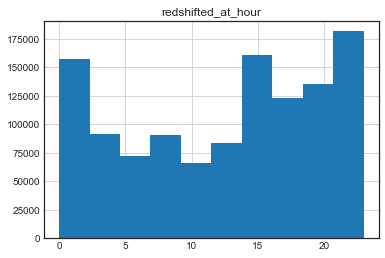

In [161]:
data_df.hist(column='redshifted_at_hour')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x115028668>]], dtype=object)

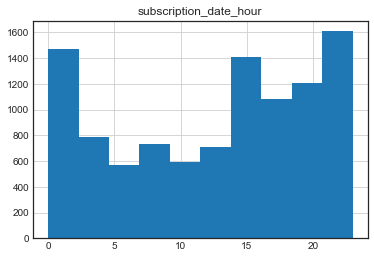

In [170]:
data_df[['id', 'subscription_date_hour']].drop_duplicates().hist(column='subscription_date_hour')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1146d0978>]], dtype=object)

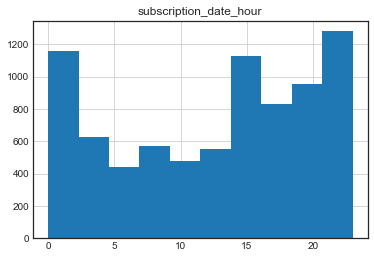

In [169]:
data_df.loc[data_df[label] == False, ['id', 'subscription_date_hour']].drop_duplicates().hist(column='subscription_date_hour')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11573fb00>]], dtype=object)

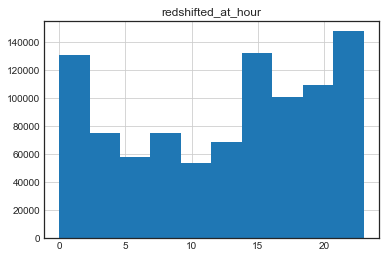

In [171]:
data_df.loc[data_df[label] == False, :].hist(column='redshifted_at_hour')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1152fa9e8>]], dtype=object)

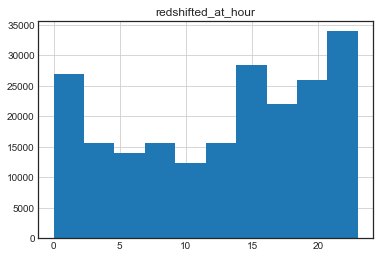

In [172]:
data_df.loc[data_df[label] == True, :].hist(column='redshifted_at_hour')

In [10]:
data_df.head()

,id,renewed,subscription_date,feature_name,redshifted_at,churned,days_since_sub,weeks_since_sub,sub_week
0,5147,False,2017-10-13 17:12:41,20,2017-10-21 13:05:45,True,8,2,41
1,7423,False,2017-10-08 19:18:56,25,2017-10-08 19:52:00,True,1,1,40
2,3491,True,2017-10-10 15:08:54,18,2017-10-11 16:47:53,False,2,1,41
3,9891,True,2017-10-15 01:12:10,3,2017-10-15 01:22:11,False,1,1,41
4,6378,True,2017-10-23 00:31:45,35,2017-10-28 16:57:53,False,6,1,43


In [12]:
user_fe_act_per_week_df.head()

,w1_f3,w1_f15,w1_f16,w1_f31,w2_f31,w1_f32,w2_f32,w1_f6,w1_f7,w2_f14,...,w4_f40,w4_f56,w3_f65,w4_f65,w3_f59,w2_f22,uniq_fe_w1,uniq_fe_w2,uniq_fe_w3,uniq_fe_w4
id,,,,,,,,,,,,,,,,,,,,,
1,1.0000,3.0000,1.0000,1.0000,1.0000,5.0000,5.0000,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,5,2,0,0
2,2.0000,nan,nan,6.0000,nan,4.0000,nan,3.0000,5.0000,1.0000,...,nan,nan,nan,nan,nan,nan,11,4,0,0
3,1.0000,4.0000,1.0000,2.0000,nan,5.0000,nan,1.0000,2.0000,nan,...,nan,nan,nan,nan,nan,nan,20,0,0,0
4,nan,nan,20.0000,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,12,4,1,1
5,4.0000,2.0000,1.0000,5.0000,nan,2.0000,nan,5.0000,5.0000,nan,...,nan,nan,nan,nan,nan,nan,29,0,8,0


In [36]:
features = ['w1_f15', 'w2_f15', 'w3_f15', 'w4_f15']
df = user_fe_act_per_week_df[features].join(data_df[['id', label]].drop_duplicates().set_index('id')).fillna(0)

for f in features:
    print(df.loc[df[label] == True, f].value_counts(normalize=True)[:6])
    print(df.loc[df[label] == False, f].value_counts(normalize=True)[:6])
    print("\n")
    
print(df.loc[:, features[0]].value_counts(normalize=True))


0.0000   0.3425
1.0000   0.1573
2.0000   0.0942
3.0000   0.0701
4.0000   0.0501
5.0000   0.0404
6.0000   0.0399
Name: w1_f15, dtype: float64
0.0000   0.3328
1.0000   0.1373
2.0000   0.0921
3.0000   0.0670
4.0000   0.0539
5.0000   0.0408
6.0000   0.0332
Name: w1_f15, dtype: float64


0.0000   0.7517
1.0000   0.0696
2.0000   0.0357
3.0000   0.0320
4.0000   0.0209
5.0000   0.0144
8.0000   0.0111
7.0000   0.0111
6.0000   0.0088
Name: w2_f15, dtype: float64
0.0000   0.6825
1.0000   0.0815
2.0000   0.0476
3.0000   0.0389
4.0000   0.0275
5.0000   0.0201
6.0000   0.0132
Name: w2_f15, dtype: float64


0.0000   0.7708
1.0000   0.0798
2.0000   0.0367
3.0000   0.0255
4.0000   0.0167
5.0000   0.0144
6.0000   0.0111
Name: w3_f15, dtype: float64
0.0000   0.6957
1.0000   0.0804
2.0000   0.0446
3.0000   0.0347
4.0000   0.0262
5.0000   0.0177
6.0000   0.0150
Name: w3_f15, dtype: float64


0.0000   0.7865
1.0000   0.0622
2.0000   0.0418
3.0000   0.0213
4.0000   0.0195
5.0000   0.0102
7.0000   0.0097
6.00

In [42]:
ctg_fe = ['w1', 'w2', 'w3', 'w4']

def usg_discretization(n):
    last_ctg = 2
    out = n
    
    if out > last_ctg: 
        out = last_ctg
    return int(out)


for i in range(len(ctg_fe)):
    df[ctg_fe[i]] = [usg_discretization(j) for j in  df[features[i]]]
    
df.head()


,w1_f15,w2_f15,w3_f15,w4_f15,churned,w1,w2,w3,w4
id,,,,,,,,,
1,3.0000,0.0000,0.0000,0.0000,False,2,0,0,0
2,0.0000,1.0000,0.0000,0.0000,False,0,1,0,0
3,4.0000,0.0000,0.0000,0.0000,True,2,0,0,0
4,0.0000,0.0000,0.0000,0.0000,False,0,0,0,0
5,2.0000,0.0000,0.0000,0.0000,True,2,0,0,0


In [61]:
n = 3
M = [[0]*n for _ in range(n)]
lbl = False
for idx, row in df.loc[df[label] == lbl, ctg_fe].sample(2000).iterrows():
    for (i,j) in zip(row, row[1:]):
        M[i][j] += 1
        #print("\nDEBUG: i = %d, j = %d" % (i,j))
        #for row in M: print(' '.join('{0:.2f}'.format(x) for x in row))

#now convert to probabilities:
for row in M:
    n = sum(row)
    if n > 0:
        row[:] = [f/sum(row) for f in row]
print("\n\n")
for row in M: print(' '.join('{0:.2f}'.format(x) for x in row))





0.84 0.06 0.10
0.69 0.11 0.20
0.44 0.10 0.46


In [53]:
0.85 0.05 0.10
0.68 0.09 0.23
0.45 0.10 0.44 #False - sample of 2000

0.88 0.05 0.07
0.75 0.09 0.15
0.53 0.10 0.37   #True

pandas.core.frame.DataFrame

In [164]:
def estimateTranMatrixMLE(df, lbl, init_p):
    import scipy.optimize as opt

    def negLogLikelihood(params):
        # params - transition probabilities
        neg_log_sum = 0
        for idx, row in df.loc[df[label] == lbl, ctg_fe].iterrows(): #.loc[:5, :] # .sample(2000).iterrows() 
            #print("\n\nrow: \n" + str(row))
            neg_log_sum += -1 * np.log(init_p[row[0]]) 
            #print("init_p[row[0]]: %f, neg_log_sum: %f" % (init_p[row[0]], neg_log_sum))
            for (i,j) in zip(row, row[1:]):
                neg_log_sum += -1 * np.log(params[i*3+j])
                #print("\ni: %d, j: %d, params[i*3+j]: %.1f, \n-1 * np.log(params[i*3+j]): %f, neg_log_sum: %f" % 
                #      (i, j, params[i*3+j], -1 * np.log(params[i*3+j]), neg_log_sum))
        return neg_log_sum

    init_params = [0.5, 0.3, 0.2,
                   0.5, 0.3, 0.2,
                   0.5, 0.3, 0.2]

    n_states = int(np.sqrt(len(init_params)))

    def con(t):
        return [sum(t[:n_states]) - 1, 
                sum(t[n_states:2*n_states]) - 1, 
                sum(t[2*n_states:]) - 1] 

    # Constraints - stochastic matrix (sum of each row in the transition matrix = 1):
    cons = [{'type':'eq', 'fun': con}] 

    #Required to have [0,1] values
    bnds = tuple((0,1) for x in init_params)

    result = opt.minimize(negLogLikelihood, init_params, bounds=bnds ,constraints=cons)
    if result.success:
        fitted_tran_probs = result.x
        print(fitted_tran_probs.reshape(n_states, n_states))
        #print("\n\n")
        #print([sum(fitted_tran_probs[:n_states]) , 
        #       sum(fitted_tran_probs[n_states:2*n_states]) , 
        #       sum(fitted_tran_probs[2*n_states:]) ])
        return fitted_tran_probs
    else:
        raise ValueError(result.message)
        return

In [165]:
lbl = True
init_p = list(df.loc[df[label] == lbl, ctg_fe[0]].value_counts(normalize=True))
tran_mat = estimateTranMatrixMLE(df=df, lbl=lbl, init_p=init_p)

[[ 0.87782967  0.05399356  0.06817677]
 [ 0.75340545  0.09379776  0.15279679]
 [ 0.532212    0.09916118  0.36862683]]


[[ 0.87782967  0.05399356  0.06817677]
 [ 0.75340545  0.09379776  0.15279679]
 [ 0.532212    0.09916118  0.36862683]]



[0.99999999999999989, 0.99999999999999989, 1.0]


In [119]:
0.88 0.05 0.07
0.75 0.09 0.15
0.53 0.10 0.37   #True


#False:
[[ 0.85715427  0.14284573  0.        ]
 [ 1.          0.          0.        ]
 [ 1.          0.          0.        ]]

[[  8.57163157e-01   1.42836843e-01   1.77765788e-15]
 [  1.00000000e+00   7.09501902e-16   0.00000000e+00]
 [  1.00000000e+00   0.00000000e+00   4.70543743e-17]]


#True:
[[  1.00000000e+00   9.49240686e-15   0.00000000e+00]
 [  5.00000000e-01   3.00000000e-01   2.00000000e-01]
 [  1.00000000e+00   5.55111512e-16   0.00000000e+00]]

[[ 1.   0.   0. ]
 [ 0.7  0.2  0.1]
 [ 1.   0.   0. ]]


SyntaxError: invalid syntax (<ipython-input-119-057ac0414cad>, line 2)

In [130]:
print([sum(fitted_tran_probs[:3]) , sum(fitted_tran_probs[n_states:2*n_states]) , sum(fitted_tran_probs[2*n_states:]) ])

[1.0000000000000355, 1.0, 1.0]


In [138]:
result

     fun: 3.699091790314821
     jac: array([-4.,  0.,  0.,  0.,  0.,  0., -2.,  0.,  0.])
 message: 'Optimization terminated successfully.'
    nfev: 22
     nit: 2
    njev: 2
  status: 0
 success: True
       x: array([  1.00000000e+00,   9.49240686e-15,   0.00000000e+00,
         5.00000000e-01,   3.00000000e-01,   2.00000000e-01,
         1.00000000e+00,   5.55111512e-16,   0.00000000e+00])

In [65]:
# # # # DATA PREPROCESSING (feature extraction, feature reduction and *feature scaling) # # # # 
from sklearn.preprocessing import MinMaxScaler

# FEATURE SCALING
scale_cols = list(pp_data_df.columns[np.where([x.startswith('fe_name_') for x in list(pp_data_df.columns)])[0]])
scale_cols += list(pp_data_df.columns[np.where([x.startswith('uniq_fe_') for x in list(pp_data_df.columns)])[0]] )
# DEBUG: print(scale_cols)

# Apply log-transformation to relevant features:
#pp_data_df[scale_cols] = pp_data_df[scale_cols].apply(lambda x: np.log(x + 1))

# MinMax scaling:
#pp_data_df.reset_index(label, inplace=True)
#minmax_cols = list(pp_data_df.columns).remove(label) #list(set(list(pp_data_df.columns)) - set([label]))
min_max_scaler = MinMaxScaler()
#pp_data_df[minmax_cols] = min_max_scaler.fit_transform(pp_data_df[minmax_cols])
scale_cols = pp_data_df.columns[np.array(pp_data_df.apply(lambda x: x.min() != 0)) |
                                np.array(pp_data_df.apply(lambda x: x.max() != 1))]
pp_data_df[scale_cols] = min_max_scaler.fit_transform(pp_data_df[scale_cols])
    
# DEBUG:
pp_data_df.describe()

,fe_name_1,fe_name_2,fe_name_3,fe_name_4,fe_name_5,fe_name_6,fe_name_7,fe_name_8,fe_name_9,fe_name_11,...,w2_f42,uniq_fe_w1,uniq_fe_w2,uniq_fe_w3,uniq_fe_w4,fe_name_other,w1_other,w2_other,w3_other,w4_other
count,"10,167.0000","10,167.0000","10,167.0000","10,167.0000","10,167.0000","10,167.0000","10,167.0000","10,167.0000","10,167.0000","10,167.0000",...,"10,167.0000","10,167.0000","10,167.0000","10,167.0000","10,167.0000","10,167.0000","10,167.0000","10,167.0000","10,167.0000","10,167.0000"
mean,0.0094,0.0093,0.0173,0.0049,0.0026,0.0064,0.0087,0.0032,0.0032,0.0024,...,0.0025,0.2969,0.1162,0.0979,0.0981,0.0002,0.0007,0.0006,0.0010,0.0006
std,0.0390,0.0300,0.0478,0.0272,0.0126,0.0236,0.0250,0.0146,0.0179,0.0160,...,0.0495,0.1693,0.1638,0.1479,0.1558,0.0108,0.0180,0.0186,0.0246,0.0154
min,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
25%,0.0000,0.0000,0.0003,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.1552,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
50%,0.0000,0.0000,0.0022,0.0000,0.0001,0.0005,0.0008,0.0000,0.0000,0.0000,...,0.0000,0.2931,0.0208,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
75%,0.0035,0.0038,0.0144,0.0008,0.0019,0.0050,0.0079,0.0009,0.0008,0.0005,...,0.0000,0.4310,0.1875,0.1667,0.1628,0.0000,0.0000,0.0000,0.0000,0.0000
max,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,...,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


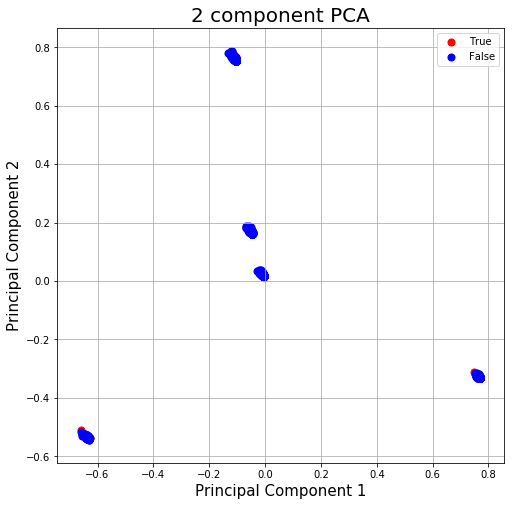

In [66]:
# 2D visualization of the data using PCA:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pc = pca.fit_transform(pp_data_df.drop(columns=label))
pca_df = pd.DataFrame(data = pc
                      , columns = ['pc1', 'pc2'])
pca_label_df = pd.concat([pca_df, pp_data_df[label]], axis = 1)

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [True, False]
colors = ['r', 'b']
for target, color in zip(targets, colors):
    indicesToKeep = pca_label_df[label] == target
    ax.scatter(pca_label_df.loc[indicesToKeep, 'pc1']
               , pca_label_df.loc[indicesToKeep, 'pc2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [68]:
pca = PCA(n_components=3)
pc = pca.fit_transform(pp_data_df.drop(columns=label))
pca_df = pd.DataFrame(data = pc)
#                      , columns = ['pc1', 'pc2'])
sum(pca.explained_variance_ratio_)

0.56354650857109445

In [73]:
# 3D visualization of the data using PCA:
# projection='3d' error (fix: https://stackoverflow.com/questions/3810865/matplotlib-unknown-projection-3d-error)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("white")
 
my_dpi=96
plt.figure(figsize=(480/my_dpi, 480/my_dpi), dpi=my_dpi)
 
# Keep the 'specie' column appart + make it numeric for coloring
my_color = ['r', 'b']
df = pp_data_df.drop(columns=label)
 
# Run The PCA
pca = PCA(n_components=3)
pca.fit(df) # fit_transform?

#pca_label_df = pd.concat([pca_df, pp_data_df[label]], axis = 1)


# Store results of PCA in a data frame
result = pd.DataFrame(pca.transform(df), columns=['PCA%i' % i for i in range(3)], index=df.index)
 
# Plot initialisation
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(result['PCA0'], result['PCA1'], result['PCA2'], c=my_color, cmap="Set2_r", s=60)
 
# make simple, bare axis lines through space:
xAxisLine = ((min(result['PCA0']), max(result['PCA0'])), (0, 0), (0,0))
ax.plot(xAxisLine[0], xAxisLine[1], xAxisLine[2], 'r')
yAxisLine = ((0, 0), (min(result['PCA1']), max(result['PCA1'])), (0,0))
ax.plot(yAxisLine[0], yAxisLine[1], yAxisLine[2], 'r')
zAxisLine = ((0, 0), (0,0), (min(result['PCA2']), max(result['PCA2'])))
ax.plot(zAxisLine[0], zAxisLine[1], zAxisLine[2], 'r')
 
# label the axes
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("PCA applied to pp_data_df")


ValueError: Unknown projection '3d'

<Figure size 480x480 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [ ]:
# FEATURE EXTRACTION
# Generate 'feature_name' usage features:
groupby_cols = ['id', label, 'feature_name', 'days_since_sub'] 
user_fe_act_per_dss_df = data_df.groupby(groupby_cols).size().reset_index().rename(columns={0: 'count'})
max_days_since_sub = user_fe_act_per_dss_df['days_since_sub'].max()
user_fe_act_per_dss_df['weight'] = user_fe_act_per_dss_df['days_since_sub'] / max_days_since_sub
user_fe_act_per_dss_df['w_count'] = user_fe_act_per_dss_df['weight'] * user_fe_act_per_dss_df['count']
# DEBUG: print(user_fe_act_per_dss_df[user_fe_act_per_dss_df['id'] == 1])
groupby_cols.remove('days_since_sub')
user_fe_act_df = user_fe_act_per_dss_df.groupby(groupby_cols).sum()
pp_data_df = user_fe_act_df.w_count.unstack('feature_name').reset_index().set_index('id')
# DEBUG: print(pp_data_df.loc[:,[3,15,16,31,32,50]].head())




# FEATURE REDUCTION
# Combining rare features per week (w1_other, w2_other, ...):
fe_missing_val_sr = pp_data_df.isnull().sum( )
num_of_users = pp_data_df.shape[0]
missing_val_threshold = 0.999 # rare feature - less than 0.1% occurences 
rare_fe_list = fe_missing_val_sr[(fe_missing_val_sr / num_of_users) > missing_val_threshold].index

pp_data_df.fillna(0, inplace=True)

print("DEBUG: preprocessed data (pp_data_df) shape BEFORE: " + str(pp_data_df.shape))

pp_data_df['other'] = pp_data_df[rare_fe_list].sum(axis=1)
print("Combining %d features into a new feature" % len(rare_fe_list))
pp_data_df.drop(columns=rare_fe_list, inplace=True)
print("DEBUG: preprocessed data (pp_data_df) shape AFTER: " + str(pp_data_df.shape))

pp_data_df.columns = pd.Series(list(pp_data_df.columns)).apply(lambda x: 'feature_name_' + str(x))
pp_data_df.rename(columns={'feature_name_churned': label}, inplace=True)

#pp_data_df.drop(columns='id', inplace=True)
#print("Delete pp_data_df 'id' column - new shape: " + str(pp_data_df.shape))

pp_data_df = pp_data_df.join(sub_week_dummies_df)
print("DEBUG: join feature_name & sub_week features. pp_data_df new shape: " + str(pp_data_df.shape))

pp_data_df.head()

In [ ]:
sub_week_cols = list(pp_data_df.columns[np.where([x.startswith('sub_week_') for x in list(pp_data_df.columns)])[0]])
gropby_cols = [label]
pp_data_df[sub_week_cols + gropby_cols].groupby(gropby_cols).sum()

In [ ]:
'''
from sklearn.preprocessing import MinMaxScaler

# FEATURE SCALING
scale_cols = pp_data_df.columns[np.where([x.startswith('feature_name_') for x in list(pp_data_df.columns)])[0]] 
print(scale_cols)
#scale_cols.remove(label)

# Apply log-transformation to all features:
pp_data_df[scale_cols] = pp_data_df[scale_cols].apply(lambda x: np.log(x + 1))

# MinMax scaling:
#pp_data_df.reset_index(label, inplace=True)
#minmax_cols = list(pp_data_df.columns).remove(label) #list(set(list(pp_data_df.columns)) - set([label]))
min_max_scaler = MinMaxScaler()
#pp_data_df[minmax_cols] = min_max_scaler.fit_transform(pp_data_df[minmax_cols])
pp_data_df[scale_cols] = min_max_scaler.fit_transform(pp_data_df[scale_cols])
    
# DEBUG:
pp_data_df.describe()
'''

In [12]:
# # # # DATA PREPROCESSING (feature extraction, feature reduction and *feature scaling) # # # # 
from sklearn.preprocessing import MinMaxScaler

# FEATURE SCALING
scale_cols = list(pp_data_df.columns[np.where([x.startswith('fe_name_') for x in list(pp_data_df.columns)])[0]])
scale_cols += list(pp_data_df.columns[np.where([x.startswith('uniq_fe_') for x in list(pp_data_df.columns)])[0]] )
print(scale_cols)
#scale_cols.remove(label)

# Apply log-transformation to relevant features:
pp_data_df[scale_cols] = pp_data_df[scale_cols].apply(lambda x: np.log(x + 1))

# MinMax scaling:
#pp_data_df.reset_index(label, inplace=True)
#minmax_cols = list(pp_data_df.columns).remove(label) #list(set(list(pp_data_df.columns)) - set([label]))
min_max_scaler = MinMaxScaler()
#pp_data_df[minmax_cols] = min_max_scaler.fit_transform(pp_data_df[minmax_cols])
pp_data_df = min_max_scaler.fit_transform(pp_data_df)
    
# DEBUG:
pp_data_df.describe()

['fe_name_1', 'fe_name_2', 'fe_name_3', 'fe_name_4', 'fe_name_5', 'fe_name_6', 'fe_name_7', 'fe_name_8', 'fe_name_9', 'fe_name_11', 'fe_name_12', 'fe_name_13', 'fe_name_14', 'fe_name_15', 'fe_name_16', 'fe_name_17', 'fe_name_18', 'fe_name_19', 'fe_name_20', 'fe_name_21', 'fe_name_23', 'fe_name_24', 'fe_name_25', 'fe_name_26', 'fe_name_27', 'fe_name_28', 'fe_name_29', 'fe_name_30', 'fe_name_31', 'fe_name_32', 'fe_name_33', 'fe_name_34', 'fe_name_35', 'fe_name_36', 'fe_name_37', 'fe_name_38', 'fe_name_39', 'fe_name_40', 'fe_name_41', 'fe_name_42', 'fe_name_43', 'fe_name_44', 'fe_name_45', 'fe_name_46', 'fe_name_47', 'fe_name_48', 'fe_name_49', 'fe_name_50', 'fe_name_51', 'fe_name_52', 'fe_name_53', 'fe_name_54', 'fe_name_55', 'fe_name_56', 'fe_name_57', 'fe_name_58', 'fe_name_59', 'fe_name_60', 'fe_name_61', 'fe_name_62', 'fe_name_63', 'fe_name_64', 'fe_name_65', 'fe_name_other', 'uniq_fe_w1', 'uniq_fe_w2', 'uniq_fe_w3', 'uniq_fe_w4']


,fe_name_1,fe_name_2,fe_name_3,fe_name_4,fe_name_5,fe_name_6,fe_name_7,fe_name_8,fe_name_9,fe_name_11,...,w2_f42,uniq_fe_w1,uniq_fe_w2,uniq_fe_w3,uniq_fe_w4,fe_name_other,w1_other,w2_other,w3_other,w4_other
count,"10,167.0000","10,167.0000","10,167.0000","10,167.0000","10,167.0000","10,167.0000","10,167.0000","10,167.0000","10,167.0000","10,167.0000",...,"10,167.0000","10,167.0000","10,167.0000","10,167.0000","10,167.0000","10,167.0000","10,167.0000","10,167.0000","10,167.0000","10,167.0000"
mean,0.0611,0.0458,0.1280,0.0278,0.0537,0.0560,0.0779,0.0318,0.0481,0.0366,...,0.0001,0.7796,0.3623,0.3247,0.3065,0.0002,0.0001,0.0002,0.0001,0.0002
std,0.1284,0.0968,0.1680,0.0809,0.0914,0.1002,0.1216,0.0731,0.1055,0.0854,...,0.0051,0.1477,0.3717,0.3632,0.3624,0.0112,0.0027,0.0059,0.0040,0.0080
min,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
25%,0.0000,0.0000,0.0074,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.7189,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
50%,0.0000,0.0000,0.0468,0.0000,0.0063,0.0080,0.0153,0.0000,0.0000,0.0000,...,0.0000,0.8262,0.3062,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
75%,0.0569,0.0302,0.2068,0.0092,0.0730,0.0759,0.1193,0.0158,0.0346,0.0186,...,0.0000,0.8854,0.7403,0.7188,0.7065,0.0000,0.0000,0.0000,0.0000,0.0000
max,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,...,0.5000,1.0000,1.0000,1.0000,1.0000,1.0000,0.1818,0.3810,0.3125,0.6250


In [ ]:
# # # # DATA PREPROCESSING (*feature extraction, feature reduction and feature scaling) # # # # 

# Label extraction - 'churned' (!renewed):
label = 'churned'
data_df[label] = (data_df['renewed'] == False)
'''(apparently ~data_df.loc[:, 'renewed'] returns -1 / -2 and not True / False)'''


# FEATURE EXTRACTION
# Compute days since subsrciption (redshifted_at - subscription_date):
data_df['days_since_sub'] = (data_df['redshifted_at'] - data_df['subscription_date']).dt.ceil("D").dt.days
# Compute weeks since subscription (w1:0-7, w2:8-14, w3:15-21, w4:22-28)
data_df['weeks_since_sub'] = pd.to_numeric(np.ceil(data_df['days_since_sub'] / 7), downcast='signed')
''' I think the feature_name that was used during subscription could be a very interesting feature 
but unfortunately there are only 69 such instances and all (but 1) have less than 10 occurrences, 
so we better just add them to week 1. '''
data_df.loc[data_df.loc[:, 'weeks_since_sub'] == 0, 'weeks_since_sub'] = 1

'''
# Generate features - combinations of feature_name & weeks from subscription 
# (e.g. w2_f1 represents the usage of feature_name 1 during week 2)
groupby_cols = ['id', label, 'feature_name', 'weeks_since_sub'] 
user_fe_act_per_week_df = data_df.groupby(groupby_cols).size().unstack(['weeks_since_sub', 'feature_name'])
new_col_names = ['w' + str(a) + '_f' + str(b)  for a,b in user_fe_act_per_week_df.columns.get_values()] 
user_fe_act_per_week_df.columns = new_col_names
#user_fe_act_per_week_df.reset_index()

# Preprocessed data - we use a deep copy of user_fe_act_per_week_df in case we would like to extract additional features later, 
#                     e.g. # of unique feature_names used in week
pp_data_df = user_fe_act_per_week_df.copy(deep=True) 
'''

groupby_cols = ['id', label, 'feature_name', 'days_since_sub'] 
user_fe_act_df = data_df.groupby(groupby_cols).size().reset_index('days_since_sub')
# Compute the weight (time decay):
user_fe_act_df['weight'] = user_fe_act_df['days_since_sub'] / max(user_fe_act_df['days_since_sub'])
user_fe_act_df['td_count']


pp_data_df.head()

In [ ]:
# TODO: REMOVE pp_data_df assignment!
pp_data_df = user_fe_act_per_week_df.copy(deep=True) 


# # # # DATA PREPROCESSING (feature extraction, *feature reduction and feature scaling) # # # # 

# FEATURE REDUCTION
# Combining rare features per week (w1_other, w2_other, ...):
fe_missing_val_sr = pp_data_df.isnull().sum( )
num_of_users = pp_data_df.shape[0]
missing_val_threshold = 0.999 # rare feature - less than 0.1% occurences 
rare_fe_list = fe_missing_val_sr[(fe_missing_val_sr / num_of_users) > missing_val_threshold].index

pp_data_df.fillna(0, inplace=True)

print("DEBUG: preprocessed data (pp_data_df) shape BEFORE: " + str(pp_data_df.shape))
for i in range(1, 5):
    w_rare_fe_list = rare_fe_list[np.where([x.startswith('w' + str(i) + '_') for x in rare_fe_list])[0]] # finds the rare features of the relevant week
    w_rare_fe_list
    pp_data_df['w' + str(i) + '_other'] = pp_data_df[w_rare_fe_list].sum(axis=1)
print("Combining %d features into %d new features" % (len(rare_fe_list), i))
pp_data_df.drop(columns=rare_fe_list, inplace=True)
print("DEBUG: preprocessed data (pp_data_df) shape AFTER: " + str(pp_data_df.shape))
# DEBUG: print('w1_f22' in pp_data_df.columns[np.where([x.startswith('w1_') for x in pp_data_df.columns])[0]]) # should be False
# DEBUG: pp_data_df.astype(bool).sum(axis=0)#[w_rare_fe_list]


In [ ]:
# # # # DATA PREPROCESSING (feature extraction, feature reduction and *feature scaling) # # # # 
from sklearn.preprocessing import MinMaxScaler

# FEATURE SCALING
# Apply log-transformation to all features:
pp_data_df = pp_data_df.apply(lambda x: np.log(x + 1))

pp_data_df.reset_index(label, inplace=True)
minmax_cols = list(set(list(pp_data_df.columns)) - set([label]))

# MinMax scaling:
min_max_scaler = MinMaxScaler()
pp_data_df[minmax_cols] = min_max_scaler.fit_transform(pp_data_df[minmax_cols])
    
# DEBUG:
pp_data_df.head()

In [ ]:
# Correlation analysis:
abs_corr_df = pp_data_df.corr().abs() # correlation matrix, INCLUDING the labels - to find perfect predictors if exist
# the matrix is symmetric so we need to extract upper triangle matrix without diagonal (k = 1):
ordered_abs_corr = (abs_corr_df.where(np.triu(np.ones(abs_corr_df.shape), k = 1).astype(np.bool)).stack().sort_values(ascending=False))
print("Correlations stas of feature-feature & feature-label: \n%s" % ordered_abs_corr.describe())
#pp_data_df.describe()
ordered_abs_corr.reset_index()

In [ ]:
# TODO: this should be done once we have the training dataset (after the split!)
# REMOVE OUTLIERS 
from sklearn.neighbors import LocalOutlierFactor

# Fit LOF
lof_clf = LocalOutlierFactor(n_neighbors=20, n_jobs=-1)
lof_pred = lof_clf.fit_predict(pp_data_df.drop(columns=label))
print(("DEBUG: Before outliers cleaning - pct of class 1 samples = %.4f") % 
      (100*sum(pp_data_df[label])/pp_data_df.shape[0]))
outlier_idx = pp_data_df.index[np.where(lof_pred == -1)[0]]
pp_data_df.drop(index=outlier_idx, inplace=True)
print(("DEBUG: After outliers cleaning - pct of class 1 samples = %.4f (%d instances)") % 
      (100*sum(pp_data_df[label])/pp_data_df.shape[0], sum(pp_data_df[label] == True)))
print(("%d outlier samples were deleted. New shape of pp_data_df: %s") % (len(outlier_idx), pp_data_df.shape))



# TODO: REMOVE setting pp_data_df
#pp_data_df_beckup = pp_data_df.copy(deep=True)
#pp_data_df = pp_data_df_beckup.reset_index(label) # add the label as a column

In [ ]:
3*0.0357

In [ ]:
def evaluateFittedClassifiers(X_test, y_test, clf_list):
    # # # # # # # # # #
    # Evaluate FITTED classifiers - conf. matrix, precision, recall, f1, AUC
    # Args:
    #       X_test - (pandas dataframe), the test design matrix
    #       y_test - (pandas series), the test labels
    #       clf_list - (list of sklearn classifier objects AFTER FITTING)
    # Return:
    #       Nothing
    # # # # # # # # # #
    from sklearn import metrics

    for clf in clf_list:
        print("\nEvaluate classifier: %s" % type(clf))
        y_pred = clf.predict(X_test)
        print("Confusion matrix:\n%s" % pd.crosstab(y_pred, y_test, rownames=['Predicted'], colnames=['True'], margins=True))#metrics.confusion_matrix(y_test, y_pred))
        print("clf report:\n%s" % metrics.classification_report(y_test, y_pred))
        print("AUC = %f" % metrics.roc_auc_score(y_test, y_pred))

    return

In [ ]:
X = pp_data_df.drop(columns=label) # design matrix
y = pp_data_df[label].astype(int) # label

from sklearn.model_selection import train_test_split
sub_cols = ['uniq_fe_w1', 'uniq_fe_w2', 'uniq_fe_w3', 'uniq_fe_w4']

X_train, X_test, y_train, y_test = train_test_split(X[sub_cols], y, test_size=0.33, random_state=42)

from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train, y_train)
evaluateFittedClassifiers(X_test, y_test, [lr])
print('intercept:', lr.intercept_)
print(lr.coef_)

best_clf = LogisticRegression()
pd.Series(lr.coef_[0]).describe()

In [ ]:
from pandas.plotting import scatter_matrix
import random
# Scatter plot of numeric features:
sample_idx = random.sample(range(0, pp_data_df.shape[0] - 1), 500)
sub_cols = [label, 'uniq_fe_w1', 'uniq_fe_w2', 'uniq_fe_w3', 'uniq_fe_w4']
pp_data_df[label] = pp_data_df[label].astype(int)
scatter_matrix(pp_data_df.loc[sample_idx, sub_cols])

In [ ]:
def plotTopFeatures(coef_nparr, fe_name_list, top_features=20):
    # # # # # # # # # #
    # Plots the k min and max coefficients
    # Args:
    #       coef_nparr - (numpy ndarray), the model's coefficients
    #       fe_name_list - (list of strings), the features names
    #       top_features - (int), k
    # Return:
    #       Nothing
    # # # # # # # # # #
    
    top_positive_coefficients = np.argsort(coef_nparr)[-top_features:]
    top_negative_coefficients = np.argsort(coef_nparr)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    # Create plot
    plt.figure(figsize=(15, 5))
    colors = ['red' if c < 0 else 'blue' for c in coef_nparr[top_coefficients]]
    plt.bar(np.arange(2 * top_features), coef_nparr[top_coefficients], color=colors)
    feature_names = np.array(fe_name_list)
    plt.xticks(np.arange(0,  2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
    return

In [ ]:
# Plot the most important features of the best classifier:
best_clf.fit(X, y)  # train the best classifier on the entire dataset
# SVM:
if (str(type(best_clf)) in ["<class 'sklearn.svm.classes.SVC'>",
                            "<class 'sklearn.linear_model.logistic.LogisticRegression'>"]):  
    coefs = best_clf.coef_.ravel()
# Decision Tree / Random Forest:
elif (str(type(clf)) in ["<class 'sklearn.ensemble.forest.RandomForestClassifier'>", 
                         "<class 'sklearn.tree.tree.DecisionTreeClassifier'>"]):
    coefs = clf.feature_importances_.ravel()
else:
    coefs = []
    print("Unrecognized model, we cannot plot the model's most important features.")
plotTopFeatures(coefs, X.columns, top_features=20)
print("End of script")

In [ ]:


# # # # DEFINE CLASSIFIERS (Decision Tree, Random Forest, Logistic Regression) # # # # 

from sklearn.ensemble import RandomForestClassifier


rf1 = RandomForestClassifier(max_depth=20, random_state=0, min_samples_leaf=20)
rf2 = RandomForestClassifier(max_depth=19, random_state=0, min_samples_leaf=20)
rf3 = RandomForestClassifier(max_depth=18, random_state=0, min_samples_leaf=20)
rf4 = RandomForestClassifier(max_depth=17, random_state=0, min_samples_leaf=20)
rf5 = RandomForestClassifier(max_depth=16, random_state=0, min_samples_leaf=20)




clf_list = [rf1, rf2, rf3, rf4, rf5]

In [112]:
# # # # DEFINE CLASSIFIERS (Decision Tree, Random Forest, Logistic Regression) # # # # 

from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

dt = tree.DecisionTreeClassifier(max_depth=20, min_samples_leaf=20)
rf = RandomForestClassifier(max_depth=20, random_state=0, min_samples_leaf=20)
lr = LogisticRegression()
knn = KNeighborsClassifier(n_neighbors=3)
svm = SVC(kernel='linear')
#svm_p = SVC(kernel='polynomial')
svm_r = SVC(kernel='rbf')
svm_s = SVC(kernel='sigmoid')



clf_list = [dt, rf, lr, knn]#, svm, svm_r, svm_s] #svm_p

In [113]:
#scores = cross_validate(lasso, X, y, scoring=('r2', 'neg_mean_squared_error'))
# TODO: REMOVE setting pp_data_df
#pp_data_df_beckup = pp_data_df.copy(deep=True)
#pp_data_df = pp_data_df_beckup.reset_index(label) # add the label as a column

#### EVALUATE CLASSIFIERS (precision, recall, f1) AND CHOOSE THE BEST ONE ####

from sklearn.model_selection import cross_validate, ShuffleSplit

#pp_data_df.reset_index(label, inplace=True) # add the label as a column
X = pp_data_df.drop(columns=label) # design matrix
y = pp_data_df[label] # label

# It is essential to set the seed (random_state) to be able to compare the classifiers performance
#cv = ShuffleSplit(n_splits=5, test_size=0.4, random_state=0) 
scoring = ('precision', 'recall', 'f1')
f1_scores = []
for clf in clf_list:
    print(("\nEvaluate classifier: %s") % type(clf))
    scores = cross_validate(clf, X, y, cv=5, scoring=scoring, n_jobs=-1)
    f1_scores.append(scores["test_f1"].mean())
    for s in scoring:
        print("(class 1 train) %s: %f" % (s, scores["train_" + s].mean()))
        print("(class 1 test) %s: %f" % (s, scores["test_" + s].mean()))
f1_scores = np.array(f1_scores)
best_clf = clf_list[np.where(f1_scores == max(f1_scores))[0][0]]
print(("\nWe recommend using the following classifier for predicting %s:\n%s") % (label, best_clf))


Evaluate classifier: <class 'sklearn.tree.tree.DecisionTreeClassifier'>
(class 1 train) precision: 0.590957
(class 1 test) precision: 0.256665
(class 1 train) recall: 0.173550
(class 1 test) recall: 0.208353
(class 1 train) f1: 0.267115
(class 1 test) f1: 0.157480

Evaluate classifier: <class 'sklearn.ensemble.forest.RandomForestClassifier'>


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning:

(class 1 train) precision: 0.200000
(class 1 test) precision: 0.000000
(class 1 train) recall: 0.000116
(class 1 test) recall: 0.000000
(class 1 train) f1: 0.000232
(class 1 test) f1: 0.000000

Evaluate classifier: <class 'sklearn.linear_model.logistic.LogisticRegression'>


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


(class 1 train) precision: 0.393333
(class 1 test) precision: 0.100000
(class 1 train) recall: 0.000928
(class 1 test) recall: 0.000464
(class 1 train) f1: 0.001852
(class 1 test) f1: 0.000924

Evaluate classifier: <class 'sklearn.neighbors.classification.KNeighborsClassifier'>


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


(class 1 train) precision: 0.694696
(class 1 test) precision: 0.156028
(class 1 train) recall: 0.403132
(class 1 test) recall: 0.470534
(class 1 train) f1: 0.510157
(class 1 test) f1: 0.230051

We recommend using the following classifier for predicting churned:
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')


In [ ]:

# TODO: REMOVE pp_data_df assignment!
pp_data_df = user_fe_act_per_week_df.copy(deep=True) 


# # # # DATA PREPROCESSING (feature extraction, *feature reduction and feature scaling) # # # # 

# FEATURE REDUCTION
# Combining rare features per week (w1_other, w2_other, ...):
fe_missing_val_sr = user_fe_act_per_week_df.isnull().sum( )
num_of_users = user_fe_act_per_week_df.shape[0]
missing_val_threshold = 0.999 # rare feature - less than 0.1% occurences 
rare_fe_list = fe_missing_val_sr[(fe_missing_val_sr / num_of_users) > missing_val_threshold].index

pp_data_df.fillna(0, inplace=True)

print("DEBUG: preprocessed data (pp_data_df) shape BEFORE: " + str(pp_data_df.shape))
for i in range(1, 5):
    w_rare_fe_list = rare_fe_list[np.where([x.startswith('w' + str(i) + '_') for x in rare_fe_list])[0]] # finds the rare features of the relevant week
    w_rare_fe_list
    pp_data_df['w' + str(i) + '_other'] = pp_data_df[w_rare_fe_list].sum(axis=1)
print("Combining %d features into %d new features" % (len(rare_fe_list), i))
pp_data_df.drop(columns=rare_fe_list, inplace=True)
print("DEBUG: preprocessed data (pp_data_df) shape AFTER: " + str(pp_data_df.shape))
# DEBUG: print('w1_f22' in pp_data_df.columns[np.where([x.startswith('w1_') for x in pp_data_df.columns])[0]]) # should be False
# DEBUG: pp_data_df.astype(bool).sum(axis=0)#[w_rare_fe_list]




In [ ]:
# TODO: REMOVE setting pp_data_df
#pp_data_df_beckup = pp_data_df.copy(deep=True)
pp_data_df = pp_data_df_beckup.reset_index().drop(columns='id') # add the label as a column & remove id (from index)


from sklearn.model_selection import KFold, cross_validate, ShuffleSplit
from sklearn.neighbors import LocalOutlierFactor

#pp_data_df.reset_index(label, inplace=True) # add the label as a column
X = pp_data_df.drop(columns=label) # design matrix
y = pp_data_df[label] # label

kf = KFold(n_splits=5, random_state=0, shuffle=True)

fold = 1
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    print("\nDEBUG: fold %d; design matrix shape: train - %s, test - %s" % (fold, X_train.shape, X_test.shape))
    print("DEBUG: pct of class 1 in: train - %.4f, test - %.4f" % (100*sum(y_train)/len(y_train), 100*sum(y_test)/len(y_test)))
    train_df = X_train.copy(deep=True)
    train_df[label] = y_train
    # Correlation analysis:
    abs_corr_df = train_df.corr() # correlation matrix, INCLUDING the labels - to find perfect predictors if exist
    # the matrix is symmetric so we need to extract upper triangle matrix without diagonal (k = 1):
    ordered_abs_corr = (abs_corr_df.where(np.triu(np.ones(abs_corr_df.shape), k = 1).astype(np.bool)).stack().sort_values(ascending=False))
    print("Correlations stas of feature-feature & feature-label: \n%s" % ordered_abs_corr.describe())
    
    # REMOVE OUTLIERS 

    # Fit LOF
    lof_clf = LocalOutlierFactor(n_neighbors=20, n_jobs=-1)
    lof_pred = lof_clf.fit_predict(train_df)
    print("DEBUG: Before (training) outliers cleaning - pct of class 1 samples = %.4f" % 
          (100*sum(y_train)/len(y_train)))
    outlier_idx = np.where(lof_pred == -1)[0]
    X_train.drop(index=outlier_idx, inplace=True)
    y_train.drop(index=outlier_idx, inplace=True)
    print(("DEBUG: After (training) outliers cleaning - pct of class 1 samples = %.4f") % 
          (100*sum(y_train)/len(y_train)))
    print(("%d outlier samples were deleted.") % len(outlier_idx))

    fold += 1